# Matched Field Processing with KRAKEN Acoustic Propagation Model

This notebook demonstrates how to use TritonOA and KRAKEN to perform matched field processing (MFP) using the Munk sound speed profile.

In [77]:
import matplotlib.pyplot as plt
import numpy as np

from tritonoa.at.models.kraken import runner
from tritonoa.plotting import plot_ambiguity_surface
from tritonoa.sp.beamforming import covariance
from tritonoa.sp.mfp import MatchedFieldProcessor
from tritonoa.ssp import munk_ssp

# Shallow-water, isospeed sound speed profile
z_data = np.array([0, 300])
c_data = np.array([1500, 1500])

environment = {
    # 1. General
    "title": "Iso-speed",
    "model": "KRAKEN",
    # 2. Top medium (halfspace)
    # 3. Layered media
    "layerdata": [{"z": z_data, "c_p": c_data, "rho": 1.0}],
    # 4. Bottom medium
    "bot_opt": "A",
    "bot_c_p": 1580,
    "bot_rho": 1.76,
    "bot_a_p": 0.2,
    # 5. Speed constraints
    "clow": 0,
    "chigh": 1600,
    # 6. Receiver parameters
    "rec_z": np.arange(130, 194, 4).tolist(),  # 16-element array w/ 4-m spacing
    "rec_r": 5.0,
    # "tilt": -1,
    # 7. Source parameters
    "src_z": 100.0,
}

freqs = [50, 100, 150, 200]

covariance_matrix = []
for f in freqs:
    p_actual = runner.run_kraken(
        environment | {"freq": f}
    )  # Add the frequency to the environment
    K = covariance(p_actual)
    covariance_matrix.append(K)

processor = MatchedFieldProcessor(
    runner=runner.run_kraken,
    covariance_matrix=covariance_matrix,
    freq=freqs,
    parameters=environment,
)

# Search space for range & depth
rvec = np.linspace(1, 10, 1000)  # km
zvec = np.linspace(1, 200, 100)  # m

# MFP Loop
ambiguity_surface = np.zeros((len(zvec), len(rvec)))
for zz, z in enumerate(zvec):
    ambiguity_surface[zz, :] = processor({"src_z": z, "rec_r": rvec})

Next, the ambiguity surface is normalized and plotted with a decibel scale.

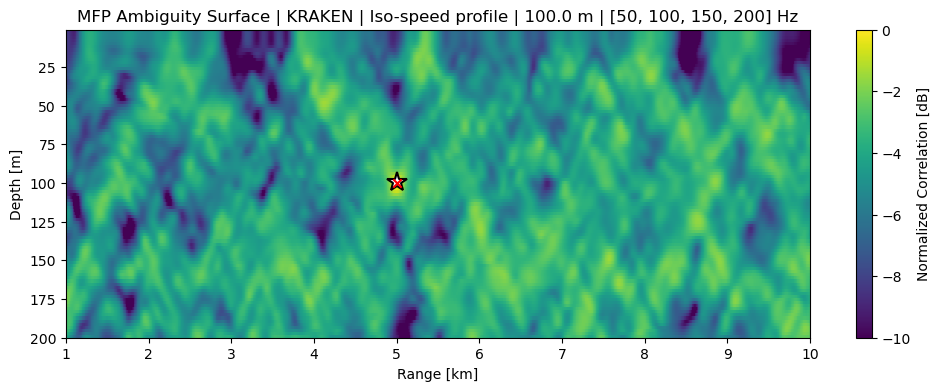

In [78]:
amb_norm = np.abs(ambiguity_surface)
amb_norm /= amb_norm.max()
amb_norm = 10 * np.log10(amb_norm)

fig = plt.figure(figsize=(12, 4), facecolor="white", dpi=100)
_, im = plot_ambiguity_surface(amb_norm, rvec, zvec, imshow_kwargs={"vmin": -10})
plt.scatter(
    environment["rec_r"], environment["src_z"], marker="x", color="red", zorder=50
)
plt.xlabel("Range [km]")
plt.ylabel("Depth [m]")
plt.title(
    f"MFP Ambiguity Surface | {environment['model']} | {environment['title']} profile | {environment['src_z']} m | {freqs} Hz"
)
cbar = plt.colorbar(im)
cbar.set_label("Normalized Correlation [dB]")
plt.show()